### Code to run calculations in parallel

In [1]:
import kwant, sys, math, os
import numpy as np
import scipy, pandas
import ipyparallel as ipp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numpy import cos, sin, exp, pi
from IPython.display import clear_output
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline

import modules.parameters as param
import modules.functions as func
import modules.shapes as shapes
import modules.plotting as plot
from modules.pauli import s0,sx,sy,sz
from modules.custom_functions import *

cwd = os.getcwd()

c:\Users\chenx\anaconda3\envs\py38\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "
C:\Users\chenx\AppData\Local\Temp\ipykernel_65984\1892018573.py:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
# Must start engines first; open a jupyter terminal and run the commands:
# module load anaconda
# source activate [environment name]
# ipcluster start -n [number of engines]

client = ipp.Client()
view = client[:]
view.push(dict(cwd=cwd))

Waiting for connection file: ~\.ipython\profile_default\security\ipcontroller-client.json


OSError: Connection file '~\\.ipython\\profile_default\\security\\ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [3]:
%%px 
# cell magic: import modules on all engines

import kwant, sys
import numpy as np

sys.path.append(cwd)

import modules.functions as func
import modules.parameters as param
import modules.shapes as shapes
from modules.custom_functions import *
from modules.pauli import s0,sx,sy,sz

UsageError: Cell magic `%%px` not found.


### Band structure

In [4]:
# build system in topological phase
L = 100
Ez = Bz = 0
lamb, mu = 1, 0
k_x = k_y = 0

syst_pars = dict(lamb=lamb, mu=mu, Ez=Ez, Bz=Bz, k_x=k_x, k_y=k_y)

bulk, WTe2, bulk_sym = func.WTe2_template(lamb=lamb, mu=mu)

sym = bulk_sym.subgroup((0, 1))
syst = kwant.Builder(sym)
syst.fill(bulk, shapes.y_ribbon(WTe2, Lx=L), (0, 0), max_sites=float('inf'));

syst_wrap = kwant.wraparound.wraparound(syst, coordinate_names=('y'))
systf = syst_wrap.finalized()

In [5]:
# calculate bands

k_vals = np.linspace(-pi, pi, 201)
energies = np.zeros((201,L*8-4))

for i,k in enumerate(k_vals):
    syst_pars['k_y'] = k
    energies[i,:] = np.linalg.eigvalsh(systf.hamiltonian_submatrix(params=syst_pars))

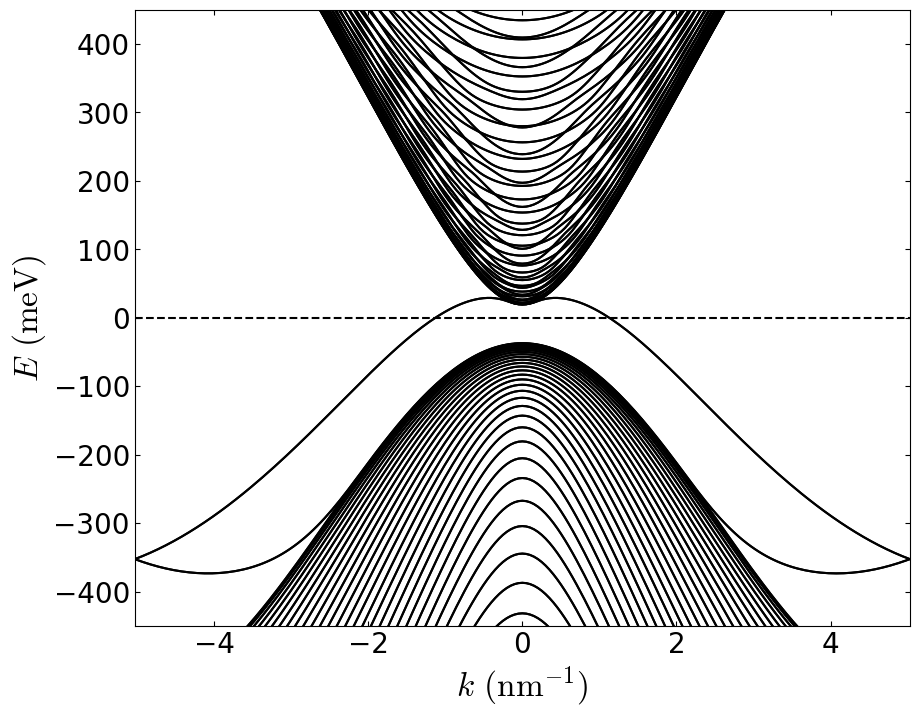

In [6]:
# plot bands

plt.figure(figsize=(10,8))
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.plot(k_vals/param.b*10, 1000*energies, 'k')
plt.xlabel(r'$k$ $\mathrm{(nm^{-1})}$', fontsize=24)
plt.ylabel(r'$E$ $\mathrm{(meV)}$', fontsize=24)
plt.tick_params(direction='in', right=True, top=True)
plt.xlim(-pi/param.b*10,pi/param.b*10)
plt.ylim(-450, 450)
plt.axhline(0, c='k', ls='--')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [7]:
# build system in trivial phase
L = 100
Ez = Bz = 0
lamb, mu = 0, 0
k_x = k_y = 0

syst_pars = dict(lamb=lamb, mu=mu, Ez=Ez, Bz=Bz, k_x=k_x, k_y=k_y)

bulk, WTe2, bulk_sym = func.WTe2_template(lamb=lamb, mu=mu)

sym = bulk_sym.subgroup((0, 1))
syst = kwant.Builder(sym)
syst.fill(bulk, shapes.y_ribbon(WTe2, Lx=L), (0, 0), max_sites=float('inf'));

syst_wrap = kwant.wraparound.wraparound(syst, coordinate_names=('y'))
systf = syst_wrap.finalized()

In [8]:
# calculate bands

k_vals = np.linspace(-pi, pi, 201)
energies = np.zeros((201,L*8-4))

for i,k in enumerate(k_vals):
    syst_pars['k_y'] = k
    energies[i,:] = np.linalg.eigvalsh(systf.hamiltonian_submatrix(params=syst_pars))

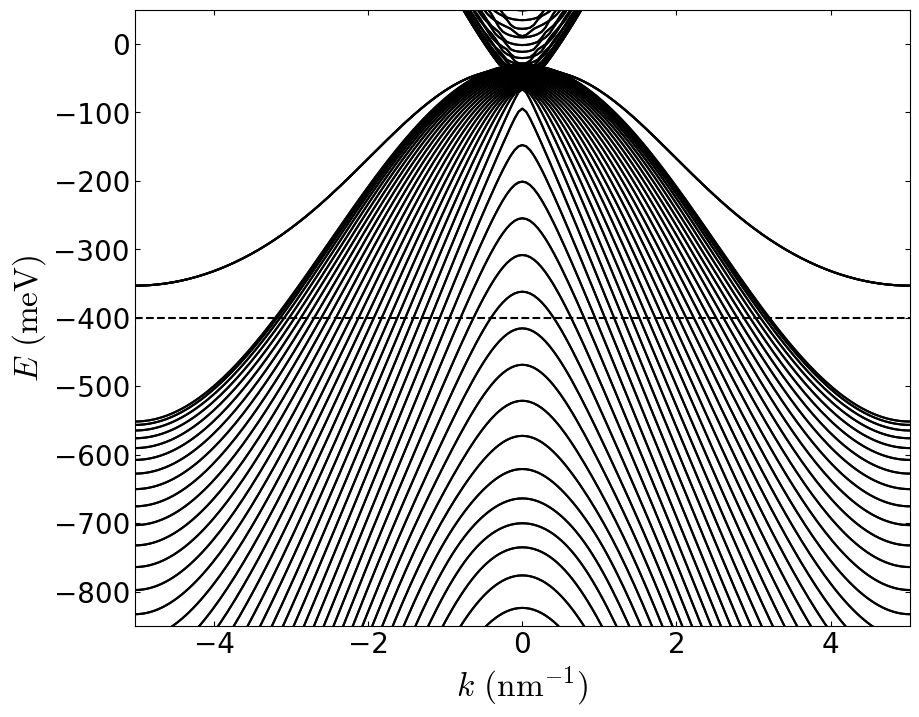

In [9]:
# plot bands

plt.figure(figsize=(10,8))
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.plot(k_vals/param.b*10, 1000*energies, 'k')
plt.xlabel(r'$k$ $\mathrm{(nm^{-1})}$', fontsize=24)
plt.ylabel(r'$E$ $\mathrm{(meV)}$', fontsize=24)
plt.tick_params(direction='in', right=True, top=True)
plt.xlim(-pi/param.b*10,pi/param.b*10)
plt.ylim(-850, 50)
plt.axhline(-400, c='k', ls='--')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### On-site scalar disorder

In [10]:
#constant parameters
num_samples = 100

E = 0
mu, mu_lead = 0, -.4
params = dict(Ez=0, Bz=0)

#Lx, Ly, Wlead, Llead = 300, 250, 120, 0
#barrier_width = 200
Lx, Ly, Wlead, Llead = 300, 200, 120, 0
barrier_width = 200

xval, yval, zval = 0, 4.242, 1
sym_vec = (xval*sx + yval*sy + zval*sz)/np.sqrt(xval**2 + yval**2 + zval**2)
disorder_direction = s0

param_dict = dict(E=E, mu=mu, mu_lead=mu_lead, params=params, Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead, num_samples=num_samples, 
                  sym_vec=sym_vec, disorder_direction=disorder_direction, barrier_width=barrier_width)
view.push(param_dict)


#changing parameter
disorder_strengths = np.linspace(0, .6, 32)
view.scatter('strengths', disorder_strengths)

NameError: name 'view' is not defined

In [9]:
%%px
#calculate conductances

Gr_matrices, Gc_matrices, Gs_matrices = [], [], []
for strength in strengths:
    
    Gr_i, Gc_i, Gs_i = [], [], []
    for sample in range(num_samples):
        
        syst, WTe2 = build_Hjunction(Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead, mu=mu, mu_lead=mu_lead,
                                     zigzag=False, sym_vec=sym_vec)

        barrier_shape = lambda pos: rectangle(pos, x1=-Lx/2, x2=Lx/2, y1=-barrier_width/2, y2=barrier_width/2)
        syst = add_Anderson_disorder(syst, WTe2, 0, strength, alligned=True, spin=disorder_direction, shape=barrier_shape)

        syst = syst.finalized()

        Gr, Gc, Gs = conductances_Landauer_nTerm(syst, V_test=.001, E=E, params=params)
        
        Gr_i += [Gr[:,0::2] + Gr[:,1::2]]
    Gr_matrices += [Gr_i]

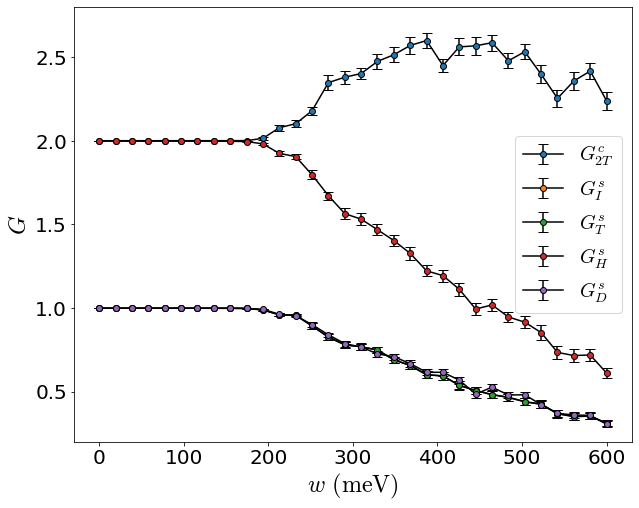

In [10]:
# Lx=300, Ly=200, Wlead=120, Llead=0, barrier_width=200

Gr = np.array(view.gather('Gr_matrices').get())
Gc, Gs = Gr[:,:,0::2,:] + Gr[:,:,1::2,:], Gr[:,:,0::2,:] - Gr[:,:,1::2,:]

Gc_C = Gc[:,:,2,0] + Gc[:,:,2,1] + Gc[:,:,3,0] + Gc[:,:,3,1]
Gs_I = -.5*(Gs[:,:,0,0] - Gs[:,:,0,1] + Gs[:,:,1,0] - Gs[:,:,1,1])
Gs_T = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,3,0] - Gs[:,:,3,1])
Gs_H = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,2,2] - Gs[:,:,2,3] + Gs[:,:,3,0] - Gs[:,:,3,1] + Gs[:,:,3,2] - Gs[:,:,3,3])
Gs_D = .5*(Gs[:,:,2,0] - Gs[:,:,2,3])

Gc_C_avg, Gc_C_std = np.mean(Gc_C, 1), np.std(Gc_C, 1)/np.sqrt(num_samples)
Gs_I_avg, Gs_I_std = np.mean(Gs_I, 1), np.std(Gs_I, 1)/np.sqrt(num_samples)
Gs_T_avg, Gs_T_std = np.mean(Gs_T, 1), np.std(Gs_T, 1)/np.sqrt(num_samples)
Gs_H_avg, Gs_H_std = np.mean(Gs_H, 1), np.std(Gs_H, 1)/np.sqrt(num_samples)
Gs_D_avg, Gs_D_std = np.mean(Gs_D, 1), np.std(Gs_D, 1)/np.sqrt(num_samples)

plt.figure(figsize=(10,8))
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.xlabel(r'$w$ $\mathrm{(meV)}$', fontsize=24)
plt.ylabel(r'$G$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim((.2, 2.8))
plt.errorbar(disorder_strengths*1000, Gc_C_avg, yerr=Gc_C_std, c='k', marker='o', capsize=5, mfc='C0', label=r'$G^c_{2T}$')
plt.errorbar(disorder_strengths*1000, Gs_I_avg, yerr=Gs_I_std, c='k', marker='o', capsize=5, mfc='C1', label=r'$G^s_I$')
plt.errorbar(disorder_strengths*1000, Gs_T_avg, yerr=Gs_T_std, c='k', marker='o', capsize=5, mfc='C2', label=r'$G^s_T$')
plt.errorbar(disorder_strengths*1000, Gs_H_avg, yerr=Gs_H_std, c='k', marker='o', capsize=5, mfc='C3', label=r'$G^s_H$')
plt.errorbar(disorder_strengths*1000, Gs_D_avg, yerr=Gs_D_std, c='k', marker='o', capsize=5, mfc='C4', label=r'$G^s_D$')
plt.legend(fontsize=20)
plt.show()

### TR-symmetric, spin-conserving SOC disorder

In [4]:
#constant parameters
num_samples = 100

E = 0
mu, mu_lead = 0, -.4
params = dict(Ez=0, Bz=0)

Lx, Ly, Wlead, Llead = 300, 200, 120, 0

xval, yval, zval = 0, 4.242, 1
sym_vec = (xval*sx + yval*sy + zval*sz)/np.sqrt(xval**2 + yval**2 + zval**2)

param_dict = dict(E=E, mu=mu, mu_lead=mu_lead, params=params, Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead, num_samples=num_samples, 
                  sym_vec=sym_vec, SOC_spin_conserving=True)
view.push(param_dict)

#changing parameter
SOC_vars = np.linspace(0, 6, 32)
view.scatter('SOC_vars', SOC_vars)

<AsyncResult: scatter>

In [5]:
%%px
#calculate conductances

Gr_matrices, Gc_matrices, Gs_matrices = [], [], []
for SOC_var in SOC_vars:
    
    Gr_i, Gc_i, Gs_i = [], [], []
    for sample in range(num_samples):
        
        syst, WTe2 = build_Hjunction(Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead, mu=mu, mu_lead=mu_lead, zigzag=False,
                                     sym_vec=sym_vec, SOC_var=SOC_var, SOC_spin_conserving=SOC_spin_conserving)
        syst = syst.finalized()

        Gr, Gc, Gs = conductances_Landauer_nTerm(syst, V_test=.001, E=E, params=params)
        
        Gr_i += [Gr[:,0::2] + Gr[:,1::2]]
    Gr_matrices += [Gr_i]

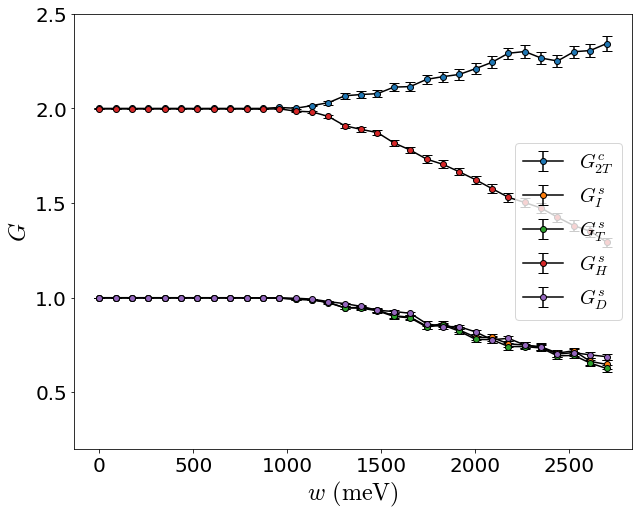

In [6]:
# Spin-conserving
# Lx=300, Ly=200, Wlead=120, Llead=0

Gr = np.array(view.gather('Gr_matrices').get())
Gc, Gs = Gr[:,:,0::2,:] + Gr[:,:,1::2,:], Gr[:,:,0::2,:] - Gr[:,:,1::2,:]

Gc_C = Gc[:,:,2,0] + Gc[:,:,2,1] + Gc[:,:,3,0] + Gc[:,:,3,1]
Gs_I = -.5*(Gs[:,:,0,0] - Gs[:,:,0,1] + Gs[:,:,1,0] - Gs[:,:,1,1])
Gs_T = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,3,0] - Gs[:,:,3,1])
Gs_H = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,2,2] - Gs[:,:,2,3] + Gs[:,:,3,0] - Gs[:,:,3,1] + Gs[:,:,3,2] - Gs[:,:,3,3])
Gs_D = .5*(Gs[:,:,2,0] - Gs[:,:,2,3])

Gc_C_avg, Gc_C_std = np.mean(Gc_C, 1), np.std(Gc_C, 1)/np.sqrt(num_samples)
Gs_I_avg, Gs_I_std = np.mean(Gs_I, 1), np.std(Gs_I, 1)/np.sqrt(num_samples)
Gs_T_avg, Gs_T_std = np.mean(Gs_T, 1), np.std(Gs_T, 1)/np.sqrt(num_samples)
Gs_H_avg, Gs_H_std = np.mean(Gs_H, 1), np.std(Gs_H, 1)/np.sqrt(num_samples)
Gs_D_avg, Gs_D_std = np.mean(Gs_D, 1), np.std(Gs_D, 1)/np.sqrt(num_samples)

plt.figure(figsize=(10,8))
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.xlabel(r'$w$ $\mathrm{(meV)}$', fontsize=24)
plt.ylabel(r'$G$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim((.2, 2.5))
plt.errorbar(SOC_vars*225, Gc_C_avg, yerr=Gc_C_std, c='k', marker='o', capsize=5, mfc='C0', label=r'$G^c_{2T}$')
plt.errorbar(SOC_vars*225, Gs_I_avg, yerr=Gs_I_std, c='k', marker='o', capsize=5, mfc='C1', label=r'$G^s_I$')
plt.errorbar(SOC_vars*225, Gs_T_avg, yerr=Gs_T_std, c='k', marker='o', capsize=5, mfc='C2', label=r'$G^s_T$')
plt.errorbar(SOC_vars*225, Gs_H_avg, yerr=Gs_H_std, c='k', marker='o', capsize=5, mfc='C3', label=r'$G^s_H$')
plt.errorbar(SOC_vars*225, Gs_D_avg, yerr=Gs_D_std, c='k', marker='o', capsize=5, mfc='C4', label=r'$G^s_D$')
plt.legend(fontsize=20)
plt.show()

### TR-symmetric, spin-nonconserving SOC disorder

In [30]:
#constant parameters
num_samples = 100

E = 0
mu, mu_lead = 0, -.4
params = dict(Ez=0, Bz=0)

Lx, Ly, Wlead, Llead = 300, 200, 120, 0

xval, yval, zval = 0, 4.242, 1
sym_vec = (xval*sx + yval*sy + zval*sz)/np.sqrt(xval**2 + yval**2 + zval**2)

param_dict = dict(E=E, mu=mu, mu_lead=mu_lead, params=params, Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead, num_samples=num_samples, 
                  sym_vec=sym_vec, SOC_spin_conserving=False)
view.push(param_dict)

#changing parameter
SOC_vars = np.linspace(0, .6, 32)
view.scatter('SOC_vars', SOC_vars)

<AsyncResult: scatter>

In [31]:
%%px
#calculate conductances

Gr_matrices, Gc_matrices, Gs_matrices = [], [], []
for SOC_var in SOC_vars:
    
    Gr_i, Gc_i, Gs_i = [], [], []
    for sample in range(num_samples):
        
        syst, WTe2 = build_Hjunction(Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead, mu=mu, mu_lead=mu_lead, zigzag=False,
                                     sym_vec=sym_vec, SOC_var=SOC_var, SOC_spin_conserving=SOC_spin_conserving)
        syst = syst.finalized()

        Gr, Gc, Gs = conductances_Landauer_nTerm(syst, V_test=.001, E=E, params=params)
        
        Gr_i += [Gr[:,0::2] + Gr[:,1::2]]
    Gr_matrices += [Gr_i]

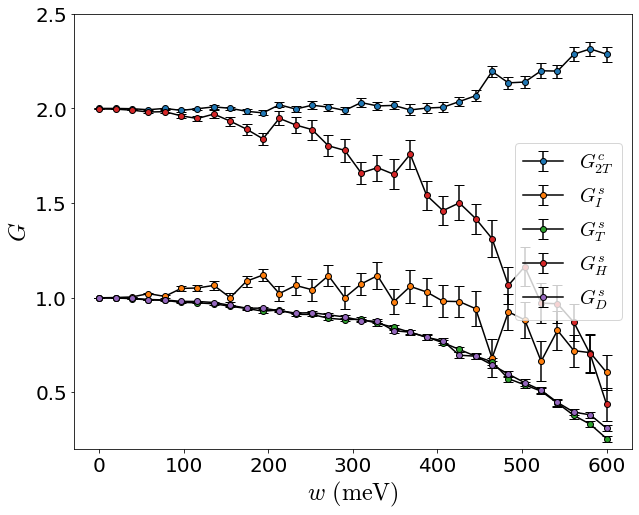

In [32]:
# Spin-nonconserving
# Lx=300, Ly=200, Wlead=120, Llead=0

Gr = np.array(view.gather('Gr_matrices').get())
Gc, Gs = Gr[:,:,0::2,:] + Gr[:,:,1::2,:], Gr[:,:,0::2,:] - Gr[:,:,1::2,:]

Gc_C = Gc[:,:,2,0] + Gc[:,:,2,1] + Gc[:,:,3,0] + Gc[:,:,3,1]
Gs_I = -.5*(Gs[:,:,0,0] - Gs[:,:,0,1] + Gs[:,:,1,0] - Gs[:,:,1,1])
Gs_T = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,3,0] - Gs[:,:,3,1])
Gs_H = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,2,2] - Gs[:,:,2,3] + Gs[:,:,3,0] - Gs[:,:,3,1] + Gs[:,:,3,2] - Gs[:,:,3,3])
Gs_D = .5*(Gs[:,:,2,0] - Gs[:,:,2,3])

Gc_C_avg, Gc_C_std = np.mean(Gc_C, 1), np.std(Gc_C, 1)/np.sqrt(num_samples)
Gs_I_avg, Gs_I_std = np.mean(Gs_I, 1), np.std(Gs_I, 1)/np.sqrt(num_samples)
Gs_T_avg, Gs_T_std = np.mean(Gs_T, 1), np.std(Gs_T, 1)/np.sqrt(num_samples)
Gs_H_avg, Gs_H_std = np.mean(Gs_H, 1), np.std(Gs_H, 1)/np.sqrt(num_samples)
Gs_D_avg, Gs_D_std = np.mean(Gs_D, 1), np.std(Gs_D, 1)/np.sqrt(num_samples)

plt.figure(figsize=(10,8))
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.xlabel(r'$w$ $\mathrm{(meV)}$', fontsize=24)
plt.ylabel(r'$G$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim((.2, 2.5))
plt.errorbar(SOC_vars*1000, Gc_C_avg, yerr=Gc_C_std, c='k', marker='o', capsize=5, mfc='C0', label=r'$G^c_{2T}$')
plt.errorbar(SOC_vars*1000, Gs_I_avg, yerr=Gs_I_std, c='k', marker='o', capsize=5, mfc='C1', label=r'$G^s_I$')
plt.errorbar(SOC_vars*1000, Gs_T_avg, yerr=Gs_T_std, c='k', marker='o', capsize=5, mfc='C2', label=r'$G^s_T$')
plt.errorbar(SOC_vars*1000, Gs_H_avg, yerr=Gs_H_std, c='k', marker='o', capsize=5, mfc='C3', label=r'$G^s_H$')
plt.errorbar(SOC_vars*1000, Gs_D_avg, yerr=Gs_D_std, c='k', marker='o', capsize=5, mfc='C4', label=r'$G^s_D$')
plt.legend(fontsize=20)
plt.show()

### Spin decay length

In [17]:
#constant parameters
num_samples = 100

E = 0
mu, mu_lead = 0, -.4
params = dict(Ez=0, Bz=0)

Lx, Ly, Wlead, Llead = 300, 50, 120, 0

xval, yval, zval = 0, 4.242, 1
sym_vec = (xval*sx + yval*sy + zval*sz)/np.sqrt(xval**2 + yval**2 + zval**2)
disorder_strength, disorder_direction = .15, sx

param_dict = dict(E=E, mu=mu, mu_lead=mu_lead, params=params, Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead,
                  num_samples=num_samples, disorder_strength=disorder_strength, sym_vec=sym_vec,
                  disorder_direction=disorder_direction, SOC_var=0)
view.push(param_dict)


#changing parameter
barrier_widths = np.linspace(10, 300, 16)
view.scatter('barrier_widths', barrier_widths)

<AsyncResult: scatter>

In [18]:
%%px
#calculate conductances

Gs_Ts = []
for barrier_width in barrier_widths:
    
    Gs_Ti = []
    for sample in range(num_samples):
        
        syst, WTe2 = build_Hjunction(Lx=Lx, Ly=barrier_width+60, Wlead=Wlead, Llead=Llead, mu=mu, mu_lead=mu_lead,
                                     zigzag=False, sym_vec=sym_vec, SOC_var=SOC_var)
        
        barrier_shape = lambda pos: rectangle(pos, x1=-Lx/2, x2=Lx/2, y1=-barrier_width/2, y2=barrier_width/2)
        syst = add_Anderson_disorder(syst, WTe2, 0, disorder_strength, alligned=True, spin=disorder_direction, shape=barrier_shape)
        
        syst = syst.finalized()

        Gs_T = transmission_conductance(syst, V_test=.001, E=E, params=params)
        
        Gs_Ti += [Gs_T]
    Gs_Ts += [Gs_Ti]

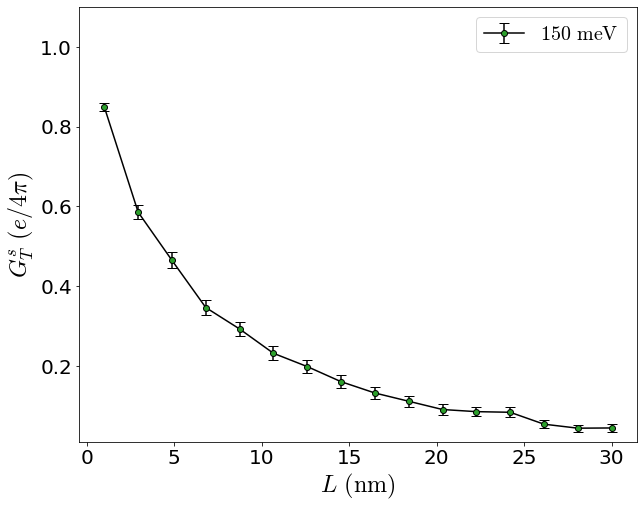

In [19]:
# scalar spin decay length

Gs_Ts = np.array(view.gather('Gs_Ts').get())
Gs_Ts_avg, Gs_Ts_std = np.mean(Gs_Ts, 1), np.std(Gs_Ts, 1)/np.sqrt(num_samples)

plt.figure(figsize=(10,8))
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.xlabel(r'$L$ $\mathrm{(nm)}$', fontsize=24)
plt.ylabel(r'$G^s_T$ $(e/4\pi)$', fontsize=24)
plt.ylim((.01, 1.1))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.errorbar(barrier_widths/10, Gs_Ts_avg, yerr=Gs_Ts_std, c='k', marker='o', capsize=5, mfc='C2', label=r'$150$ $\mathrm{meV}$')
plt.legend(fontsize=20)
plt.show()

In [ ]:
#constant parameters
num_samples = 50

E = 0
mu, mu_lead = 0, -.4
params = dict(Ez=0, Bz=0)

Lx, Ly, Wlead, Llead = 300, 50, 120, 0

xval, yval, zval = 0, 4.242, 1
sym_vec = (xval*sx + yval*sy + zval*sz)/np.sqrt(xval**2 + yval**2 + zval**2)
disorder_direction = sx

param_dict = dict(E=E, mu=mu, mu_lead=mu_lead, params=params, Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead,
                  num_samples=num_samples, sym_vec=sym_vec, disorder_direction=disorder_direction)
view.push(param_dict)


#changing parameter
disorder_strengths = np.linspace(0, .3, 64)
barrier_widths = np.linspace(10, 300, 64)
strengths, widths = np.meshgrid(disorder_strengths, barrier_widths)
strength_widths = np.array([strengths.flatten(), widths.flatten()]).T
view.scatter('strength_widths', strength_widths)

In [ ]:
%%px
#calculate conductances

Gs_Ts = []
for strength_width in strength_widths:
    disorder_strength, barrier_width = strength_width
    
    Gs_Ti = []
    for sample in range(num_samples):
        
        syst, WTe2 = build_Hjunction(Lx=Lx, Ly=barrier_width+60, Wlead=Wlead, Llead=Llead, mu=mu, mu_lead=mu_lead,
                                     zigzag=False, sym_vec=sym_vec)
        
        barrier_shape = lambda pos: rectangle(pos, x1=-Lx/2, x2=Lx/2, y1=-barrier_width/2, y2=barrier_width/2)
        syst = add_Anderson_disorder(syst, WTe2, 0, disorder_strength, alligned=True, spin=disorder_direction, shape=barrier_shape)
        
        syst = syst.finalized()
        
        Gs_T = transmission_conductance(syst, V_test=.001, E=E, params=params)
        
        Gs_Ti += [Gs_T]
    Gs_Ts += [Gs_Ti]

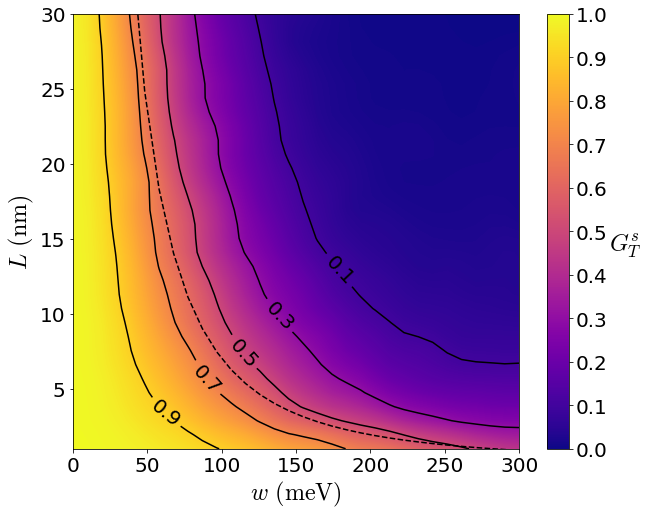

In [49]:
#straight disordered perturbation

Gs_T_avg = np.mean(Gs_Ts, 2)

z_data = Gs_T_avg
z_data_contours = gaussian_filter(z_data, 1)
z_data_fill = gaussian_filter(z_data, 1)
x_data = np.linspace(np.min(disorder_strengths), np.max(disorder_strengths), len(z_data))
y_data = np.linspace(np.min(barrier_widths), np.max(barrier_widths), len(z_data))

plt.figure(figsize=(10,8))
mpl.rcParams['mathtext.fontset'] = 'cm'

plt.xlabel(r'$w$ $\mathrm{(meV)}$', fontsize=24)
plt.ylabel(r'$L$ $\mathrm{(nm)}$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

CS = plt.contour(x_data*1000, y_data/10, z_data_contours, [.1, .3, .5, .7, .9], colors='k')
plt.contourf(x_data*1000, y_data/10, z_data_fill, 500, cmap='plasma')
manual_locations = [(180,13), (140,10), (120,8), (85,5), (60,3)]
plt.clabel(CS, fmt='%1.1f', fontsize=20, manual=manual_locations)

plt.plot(disorder_strengths*1000, 800*(barrier_widths/10)**(-2), 'k--')
plt.ylim((1,30))

cbar = plt.colorbar(ticks=np.arange(0, 1.01, .1))
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'$G^s_T$', fontsize=24, rotation=0, labelpad=18)

plt.show()

### Magnetic disorder

In [51]:
#constant parameters
num_samples = 100

E = 0
mu, mu_lead = 0, -.4
params = dict(Ez=0, Bz=0)

Lx, Ly, Wlead, Llead = 300, 200, 120, 0
barrier_width = 200

xval, yval, zval = 0, 4.242, 1
sym_vec = (xval*sx + yval*sy + zval*sz)/np.sqrt(xval**2 + yval**2 + zval**2)
disorder_direction = sx

param_dict = dict(E=E, mu=mu, mu_lead=mu_lead, params=params, Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead, num_samples=num_samples, 
                  sym_vec=sym_vec, disorder_direction=disorder_direction, barrier_width=barrier_width)
view.push(param_dict)


#changing parameter
disorder_strengths = np.linspace(0, .4, 32)
view.scatter('strengths', disorder_strengths)

<AsyncResult: scatter>

In [52]:
%%px
#calculate conductances

Gr_matrices, Gc_matrices, Gs_matrices = [], [], []
for strength in strengths:
    
    Gr_i, Gc_i, Gs_i = [], [], []
    for sample in range(num_samples):
        
        syst, WTe2 = build_Hjunction(Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead, mu=mu, mu_lead=mu_lead,
                                     zigzag=False, sym_vec=sym_vec)
        
        ### local ###
        #barrier_shape = lambda pos: rectangle(pos, x1=-Lx/2, x2=Lx/2, y1=-barrier_width/2, y2=barrier_width/2)
        #syst = add_Anderson_disorder(syst, WTe2, 0, strength, alligned=True, spin=disorder_direction, shape=barrier_shape)
        #############
        
        ### nonlocal ###
        syst = add_Anderson_disorder(syst, WTe2, 0, strength, alligned=True, spin=disorder_direction, shape=None)
        ################

        syst = syst.finalized()

        Gr, Gc, Gs = conductances_Landauer_nTerm(syst, V_test=.001, E=E, params=params)
        
        Gr_i += [Gr[:,0::2] + Gr[:,1::2]]
    Gr_matrices += [Gr_i]

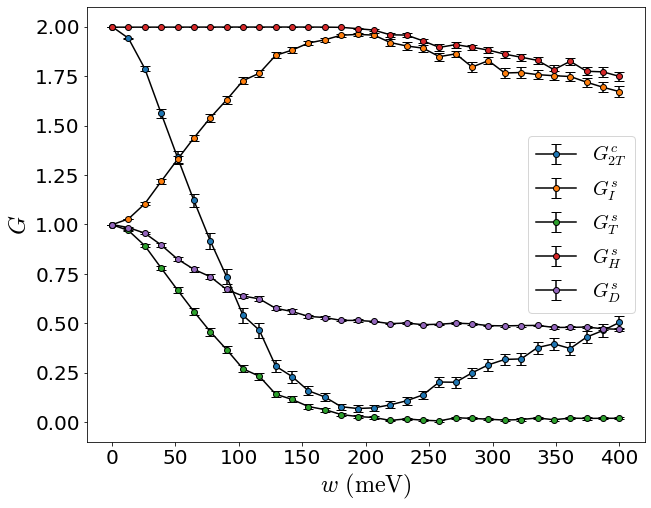

In [43]:
# Lx=300, Ly=250, Wlead=120, Llead=0, barrier_width=200

Gr = np.array(view.gather('Gr_matrices').get())
Gc, Gs = Gr[:,:,0::2,:] + Gr[:,:,1::2,:], Gr[:,:,0::2,:] - Gr[:,:,1::2,:]

Gc_C = Gc[:,:,2,0] + Gc[:,:,2,1] + Gc[:,:,3,0] + Gc[:,:,3,1]
Gs_I = -.5*(Gs[:,:,0,0] - Gs[:,:,0,1] + Gs[:,:,1,0] - Gs[:,:,1,1])
Gs_T = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,3,0] - Gs[:,:,3,1])
Gs_H = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,2,2] - Gs[:,:,2,3] + Gs[:,:,3,0] - Gs[:,:,3,1] + Gs[:,:,3,2] - Gs[:,:,3,3])
Gs_D = .5*(Gs[:,:,2,0] - Gs[:,:,2,3])

Gc_C_avg, Gc_C_std = np.mean(Gc_C, 1), np.std(Gc_C, 1)/np.sqrt(num_samples)
Gs_I_avg, Gs_I_std = np.mean(Gs_I, 1), np.std(Gs_I, 1)/np.sqrt(num_samples)
Gs_T_avg, Gs_T_std = np.mean(Gs_T, 1), np.std(Gs_T, 1)/np.sqrt(num_samples)
Gs_H_avg, Gs_H_std = np.mean(Gs_H, 1), np.std(Gs_H, 1)/np.sqrt(num_samples)
Gs_D_avg, Gs_D_std = np.mean(Gs_D, 1), np.std(Gs_D, 1)/np.sqrt(num_samples)

plt.figure(figsize=(10,8))
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.xlabel(r'$w$ $\mathrm{(meV)}$', fontsize=24)
plt.ylabel(r'$G$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.errorbar(disorder_strengths*1000, Gc_C_avg, yerr=Gc_C_std, c='k', marker='o', capsize=5, mfc='C0', label=r'$G^c_{2T}$')
plt.errorbar(disorder_strengths*1000, Gs_I_avg, yerr=Gs_I_std, c='k', marker='o', capsize=5, mfc='C1', label=r'$G^s_I$')
plt.errorbar(disorder_strengths*1000, Gs_T_avg, yerr=Gs_T_std, c='k', marker='o', capsize=5, mfc='C2', label=r'$G^s_T$')
plt.errorbar(disorder_strengths*1000, Gs_H_avg, yerr=Gs_H_std, c='k', marker='o', capsize=5, mfc='C3', label=r'$G^s_H$')
plt.errorbar(disorder_strengths*1000, Gs_D_avg, yerr=Gs_D_std, c='k', marker='o', capsize=5, mfc='C4', label=r'$G^s_D$')
plt.legend(fontsize=20)
plt.show()

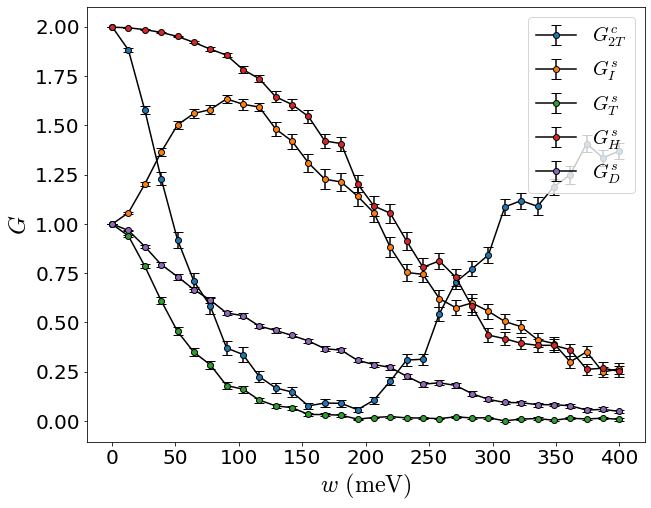

In [53]:
# Lx=300, Ly=200, Wlead=120, Llead=20, barrier_width=200

Gr = np.array(view.gather('Gr_matrices').get())
Gc, Gs = Gr[:,:,0::2,:] + Gr[:,:,1::2,:], Gr[:,:,0::2,:] - Gr[:,:,1::2,:]

Gc_C = Gc[:,:,2,0] + Gc[:,:,2,1] + Gc[:,:,3,0] + Gc[:,:,3,1]
Gs_I = -.5*(Gs[:,:,0,0] - Gs[:,:,0,1] + Gs[:,:,1,0] - Gs[:,:,1,1])
Gs_T = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,3,0] - Gs[:,:,3,1])
Gs_H = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,2,2] - Gs[:,:,2,3] + Gs[:,:,3,0] - Gs[:,:,3,1] + Gs[:,:,3,2] - Gs[:,:,3,3])
Gs_D = .5*(Gs[:,:,2,0] - Gs[:,:,2,3])

Gc_C_avg, Gc_C_std = np.mean(Gc_C, 1), np.std(Gc_C, 1)/np.sqrt(num_samples)
Gs_I_avg, Gs_I_std = np.mean(Gs_I, 1), np.std(Gs_I, 1)/np.sqrt(num_samples)
Gs_T_avg, Gs_T_std = np.mean(Gs_T, 1), np.std(Gs_T, 1)/np.sqrt(num_samples)
Gs_H_avg, Gs_H_std = np.mean(Gs_H, 1), np.std(Gs_H, 1)/np.sqrt(num_samples)
Gs_D_avg, Gs_D_std = np.mean(Gs_D, 1), np.std(Gs_D, 1)/np.sqrt(num_samples)

plt.figure(figsize=(10,8))
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.xlabel(r'$w$ $\mathrm{(meV)}$', fontsize=24)
plt.ylabel(r'$G$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.errorbar(disorder_strengths*1000, Gc_C_avg, yerr=Gc_C_std, c='k', marker='o', capsize=5, mfc='C0', label=r'$G^c_{2T}$')
plt.errorbar(disorder_strengths*1000, Gs_I_avg, yerr=Gs_I_std, c='k', marker='o', capsize=5, mfc='C1', label=r'$G^s_I$')
plt.errorbar(disorder_strengths*1000, Gs_T_avg, yerr=Gs_T_std, c='k', marker='o', capsize=5, mfc='C2', label=r'$G^s_T$')
plt.errorbar(disorder_strengths*1000, Gs_H_avg, yerr=Gs_H_std, c='k', marker='o', capsize=5, mfc='C3', label=r'$G^s_H$')
plt.errorbar(disorder_strengths*1000, Gs_D_avg, yerr=Gs_D_std, c='k', marker='o', capsize=5, mfc='C4', label=r'$G^s_D$')
plt.legend(fontsize=20)
plt.show()

### QPC system

In [17]:
#constant parameters
num_samples = 100

E = 0
mu, mu_lead = 0, -.4
params = dict(Ez=0, Bz=0)

L, W, Wlead = 300, 300, 120
L_gap, L_base, L_flat = 50, 200, 150
barrier_width = 175

xval, yval, zval = 0, 4.242, 1
sym_vec = (xval*sx + yval*sy + zval*sz)/np.sqrt(xval**2 + yval**2 + zval**2)
disorder_strength, disorder_direction = .3, s0

param_dict = dict(E=E, mu=mu, mu_lead=mu_lead, params=params, L=L, W=W, Wlead=Wlead, num_samples=num_samples,
                  sym_vec=sym_vec, disorder_strength=disorder_strength, disorder_direction=disorder_direction,
                  L_base=L_base, L_flat=L_flat, barrier_width=barrier_width)
view.push(param_dict)


#changing parameter
gap_widths = np.linspace(50, 250, 16)
view.scatter('gap_widths', gap_widths)

<AsyncResult: scatter>

In [18]:
%%px
#calculate conductances

Gr_matrices, Gc_matrices, Gs_matrices = [], [], []
for L_gap in gap_widths:
    
    Gr_i, Gc_i, Gs_i = [], [], []
    for sample in range(num_samples):
        
        ### QPC ###
        syst, WTe2 = QPC_system(L=L, W=W, Wlead=Wlead, mu=mu, mu_lead=mu_lead, lamb=1, lamb_lead=0, zigzag=False,
                       sym_vec=sym_vec, L_gap=L_gap, L_base=L_base, L_flat=L_flat)

        barrier_shape = lambda pos: rectangle(pos, x1=-W/2, x2=W/2, y1=-barrier_width/2, y2=barrier_width/2)
        syst = add_Anderson_disorder(syst, WTe2, 0, disorder_strength, alligned=True, spin=disorder_direction, shape=barrier_shape)

        syst = syst.finalized()
        
        Gr, Gc, Gs = conductances_Landauer_nTerm(syst, V_test=.001, E=E, params=params)
        
        Gr_i += [Gr[:,0::2] + Gr[:,1::2]]
    Gr_matrices += [Gr_i]

[-0.0807748   0.52392102]
[-0.07842544 -0.17957598]
[-0.07899113  0.51565657]


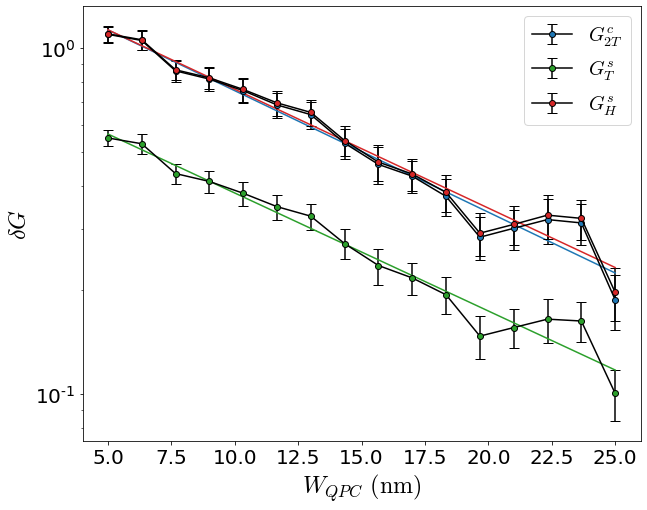

In [19]:
# vary W_QPC, alpha=.15 L_QPC=200

Gr = np.array(view.gather('Gr_matrices').get())
Gc, Gs = Gr[:,:,0::2,:] + Gr[:,:,1::2,:], Gr[:,:,0::2,:] - Gr[:,:,1::2,:]

Gc_C = Gc[:,:,2,0] + Gc[:,:,2,1] + Gc[:,:,3,0] + Gc[:,:,3,1]
Gs_T = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,3,0] - Gs[:,:,3,1])
Gs_H = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,2,2] - Gs[:,:,2,3] + Gs[:,:,3,0] - Gs[:,:,3,1] + Gs[:,:,3,2] - Gs[:,:,3,3])

Gc_C = 2 - Gc_C
Gs_T = 1 - Gs_T
Gs_H = 2 - Gs_H

Gc_C_avg, Gc_C_std = np.mean(Gc_C, 1), np.std(Gc_C, 1)/np.sqrt(num_samples)
Gs_T_avg, Gs_T_std = np.mean(Gs_T, 1), np.std(Gs_T, 1)/np.sqrt(num_samples)
Gs_H_avg, Gs_H_std = np.mean(Gs_H, 1), np.std(Gs_H, 1)/np.sqrt(num_samples)

Gc_C_fit = np.polyfit(gap_widths/10, np.log(Gc_C_avg), 1)
Gs_T_fit = np.polyfit(gap_widths/10, np.log(Gs_T_avg), 1)
Gs_H_fit = np.polyfit(gap_widths/10, np.log(Gs_H_avg), 1)

print(Gc_C_fit)
print(Gs_T_fit)
print(Gs_H_fit)

plt.figure(figsize=(10,8))
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.xlabel(r'$W_{QPC}$ $\mathrm{(nm)}$', fontsize=24)
plt.ylabel(r'$\delta G$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.errorbar(gap_widths/10, Gc_C_avg, yerr=Gc_C_std, c='k', marker='o', capsize=5, mfc='C0', label=r'$G^c_{2T}$')
plt.plot(gap_widths/10, np.exp(gap_widths/10*Gc_C_fit[0] + Gc_C_fit[1]), c='C0')
plt.errorbar(gap_widths/10, Gs_T_avg, yerr=Gs_T_std, c='k', marker='o', capsize=5, mfc='C2', label=r'$G^s_T$')
plt.plot(gap_widths/10, np.exp(gap_widths/10*Gs_T_fit[0] + Gs_T_fit[1]), c='C2')
plt.errorbar(gap_widths/10, Gs_H_avg, yerr=Gs_H_std, c='k', marker='o', capsize=5, mfc='C3', label=r'$G^s_H$')
plt.plot(gap_widths/10, np.exp(gap_widths/10*Gs_H_fit[0] + Gs_H_fit[1]), c='C3')
plt.legend(fontsize=20)
plt.show()

### Convergence

In [4]:
#constant parameters
num_samples = 1024

E = 0
mu, mu_lead = 0, -.4
params = dict(Ez=0, Bz=0)

Lx, Ly, Wlead, Llead = 300, 200, 120, 0
barrier_width = 200

xval, yval, zval = 0, 4.242, 1
sym_vec = (xval*sx + yval*sy + zval*sz)/np.sqrt(xval**2 + yval**2 + zval**2)
perp_direc = (-zval*sy + yval*sz)/np.sqrt(xval**2 + yval**2 + zval**2)
disorder_direction = sx
strengths = np.linspace(0, .4, 16)

param_dict = dict(E=E, mu=mu, mu_lead=mu_lead, params=params, Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead, num_samples=num_samples, 
                  sym_vec=sym_vec, disorder_direction=disorder_direction, barrier_width=barrier_width, strengths=strengths)
view.push(param_dict)

#changing parameter
samples = np.arange(1, num_samples+1, 1)
view.scatter('samples', samples)

<AsyncResult: scatter>

In [ ]:
%%px
#calculate conductances

Gr_matrices, Gc_matrices, Gs_matrices = [], [], []
for sample in samples:
    
    Gr_i, Gc_i, Gs_i = [], [], []
    for strength in strengths:
    
        syst, WTe2 = build_Hjunction(Lx=Lx, Ly=Ly, Wlead=Wlead, Llead=Llead, mu=mu, mu_lead=mu_lead,
                                     zigzag=False, sym_vec=sym_vec)

        ### local ###
        #barrier_shape = lambda pos: rectangle(pos, x1=-Lx/2, x2=Lx/2, y1=-barrier_width/2, y2=barrier_width/2)
        #syst = add_Anderson_disorder(syst, WTe2, 0, strength, alligned=True, spin=disorder_direction, shape=barrier_shape)
        #############

        ### nonlocal ###
        syst = add_Anderson_disorder(syst, WTe2, 0, strength, alligned=True, spin=disorder_direction, shape=None)
        ################

        syst = syst.finalized()

        Gr, Gc, Gs = conductances_Landauer_nTerm(syst, V_test=.001, E=E, params=params)
        
        Gr_i += [Gr[:,0::2] + Gr[:,1::2]]
    Gr_matrices += [Gr_i]

In [12]:
#gather data
Gr = np.array(view.gather('Gr_matrices').get())

Gc = Gr[:,:,0::2,:] + Gr[:,:,1::2,:]
Gs = Gr[:,:,0::2,:] - Gr[:,:,1::2,:]

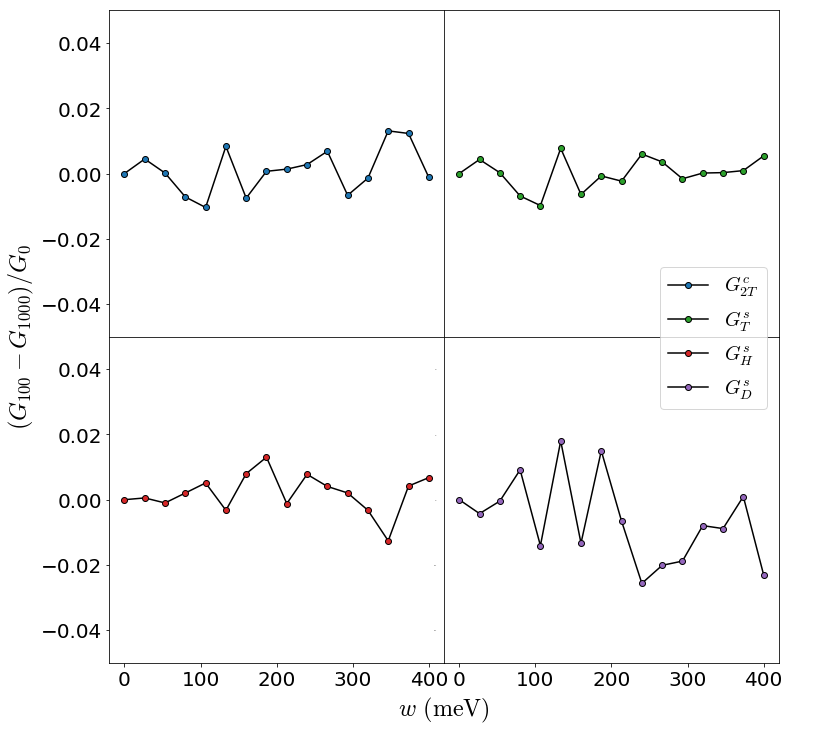

In [74]:
# 100 samples vs 1000 samples plots
samples = [300, 1000]

Gc_C = Gc[:,:,2,0] + Gc[:,:,2,1] + Gc[:,:,3,0] + Gc[:,:,3,1]
Gs_I = -.5*(Gs[:,:,0,0] - Gs[:,:,0,1] + Gs[:,:,1,0] - Gs[:,:,1,1])
Gs_T = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,3,0] - Gs[:,:,3,1])
Gs_H = .5*(Gs[:,:,2,0] - Gs[:,:,2,1] + Gs[:,:,2,2] - Gs[:,:,2,3] + Gs[:,:,3,0] - Gs[:,:,3,1] + Gs[:,:,3,2] - Gs[:,:,3,3])
Gs_D = .5*(Gs[:,:,2,0] - Gs[:,:,2,3])

Gc_C_avg, Gc_C_std = [], []
Gs_I_avg, Gs_I_std = [], []
Gs_T_avg, Gs_T_std = [], []
Gs_H_avg, Gs_H_std = [], []
Gs_D_avg, Gs_D_std = [], []

for N in samples:
    Gc_C_avg += [np.mean(Gc_C[:N], 0)]
    Gc_C_std += [np.std(Gc_C[:N], 0)/np.sqrt(N)]
    Gs_I_avg += [np.mean(Gs_I[:N], 0)]
    Gs_I_std += [np.std(Gs_I[:N], 0)/np.sqrt(N)]
    Gs_T_avg += [np.mean(Gs_T[:N], 0)]
    Gs_T_std += [np.std(Gs_T[:N], 0)/np.sqrt(N)]
    Gs_H_avg += [np.mean(Gs_H[:N], 0)]
    Gs_H_std += [np.std(Gs_H[:N], 0)/np.sqrt(N)]
    Gs_D_avg += [np.mean(Gs_D[:N], 0)]
    Gs_D_std += [np.std(Gs_D[:N], 0)/np.sqrt(N)]
    
fig = plt.figure(figsize=(12,12))

ax1 = plt.subplot(221)
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)
plt.ylim((-0.05, 0.05))
diff = Gc_C_avg[0] - Gc_C_avg[1]
plt.plot(strengths*1000, diff/2, c='k', marker='o', mfc='C0', label=r'$G^c_{2T}$')

ax2 = plt.subplot(222)
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylim((-0.05, 0.05))
diff = Gs_T_avg[0] - Gs_T_avg[1]
plt.plot(strengths*1000, diff/1, c='k', marker='o', mfc='C2', label=r'$G^s_T$')

ax3 = plt.subplot(223)
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.xticks(ticks=[0, 100, 200, 300, 400], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim((-0.05, 0.05))
diff = Gs_H_avg[0] - Gs_H_avg[1]
plt.plot(strengths*1000, diff/2, c='k', marker='o', mfc='C3', label=r'$G^s_H$')

ax4 = plt.subplot(224)
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.tick_params(which='both', top=False, bottom=True, left=False, right=False)
plt.xticks(ticks=[0, 100, 200, 300, 400], fontsize=20)
plt.yticks(fontsize=0)
plt.ylim((-0.05, 0.05))
diff = Gs_I_avg[0] - Gs_I_avg[1]
plt.plot(strengths*1000, diff/1, c='k', marker='o', mfc='C4', label=r'$G^s_D$')

plt.subplots_adjust(wspace=0, hspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'$w$ $\mathrm{(meV)}$', fontsize=24, labelpad=15)
plt.ylabel(r'$(G_{100}-G_{1000})/G_0$', fontsize=24, labelpad=50)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
handles4, labels4 = ax4.get_legend_handles_labels()
fig.legend(handles1+handles2+handles3+handles4, labels1+labels2+labels3+labels4, fontsize=20, loc=(.81,.44))

plt.show()

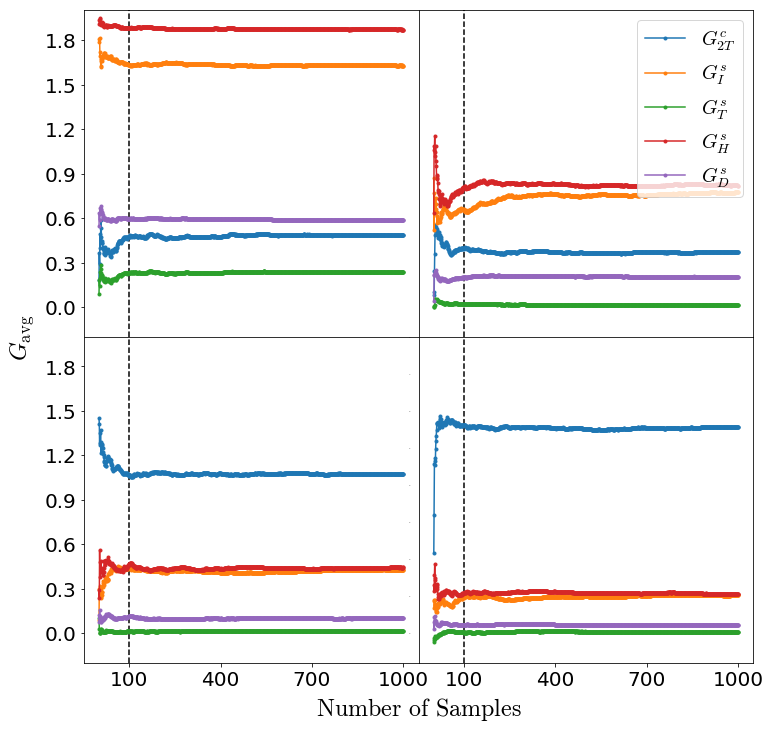

In [64]:
# conductances vs number of samples

N = 1000
w_is = [3, 9, 12, 15]

fig = plt.figure(figsize=(12,12))

w_i = w_is[0]
plt.subplot(221)
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.xticks(fontsize=0)
plt.yticks(ticks=[0, .3, .6, .9, 1.2, 1.5, 1.8], fontsize=20)
plt.ylim((-.2,2))
plt.axvline(x=100, c='k', ls='--')

Gc_C = Gc[:,w_i,2,0] + Gc[:,w_i,2,1] + Gc[:,w_i,3,0] + Gc[:,w_i,3,1]
Gs_I = -.5*(Gs[:,w_i,0,0] - Gs[:,w_i,0,1] + Gs[:,w_i,1,0] - Gs[:,w_i,1,1])
Gs_T = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,1] + Gs[:,w_i,3,0] - Gs[:,w_i,3,1])
Gs_H = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,1] + Gs[:,w_i,2,2] - Gs[:,w_i,2,3] + Gs[:,w_i,3,0] - Gs[:,w_i,3,1] + Gs[:,w_i,3,2] - Gs[:,w_i,3,3])
Gs_D = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,3])

Gc_C_avg = np.array([np.mean(Gc_C[:n+1]) for n in range(N)])
Gs_I_avg = np.array([np.mean(Gs_I[:n+1]) for n in range(N)])
Gs_T_avg = np.array([np.mean(Gs_T[:n+1]) for n in range(N)])
Gs_H_avg = np.array([np.mean(Gs_H[:n+1]) for n in range(N)])
Gs_D_avg = np.array([np.mean(Gs_D[:n+1]) for n in range(N)])

plt.plot(np.arange(N)+1, Gc_C_avg, c='C0', marker='.', mfc='C0', label=r'$G^c_{2T}$')
plt.plot(np.arange(N)+1, Gs_I_avg, c='C1', marker='.', mfc='C1', label=r'$G^s_{I}$')
plt.plot(np.arange(N)+1, Gs_T_avg, c='C2', marker='.', mfc='C2', label=r'$G^s_{T}$')
plt.plot(np.arange(N)+1, Gs_H_avg, c='C3', marker='.', mfc='C3', label=r'$G^s_{H}$')
plt.plot(np.arange(N)+1, Gs_D_avg, c='C4', marker='.', mfc='C4', label=r'$G^s_{D}$')

w_i = w_is[1]
plt.subplot(222)
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylim((-.2,2))
plt.axvline(x=100, c='k', ls='--')

Gc_C = Gc[:,w_i,2,0] + Gc[:,w_i,2,1] + Gc[:,w_i,3,0] + Gc[:,w_i,3,1]
Gs_I = -.5*(Gs[:,w_i,0,0] - Gs[:,w_i,0,1] + Gs[:,w_i,1,0] - Gs[:,w_i,1,1])
Gs_T = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,1] + Gs[:,w_i,3,0] - Gs[:,w_i,3,1])
Gs_H = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,1] + Gs[:,w_i,2,2] - Gs[:,w_i,2,3] + Gs[:,w_i,3,0] - Gs[:,w_i,3,1] + Gs[:,w_i,3,2] - Gs[:,w_i,3,3])
Gs_D = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,3])

Gc_C_avg = np.array([np.mean(Gc_C[:n+1]) for n in range(N)])
Gs_I_avg = np.array([np.mean(Gs_I[:n+1]) for n in range(N)])
Gs_T_avg = np.array([np.mean(Gs_T[:n+1]) for n in range(N)])
Gs_H_avg = np.array([np.mean(Gs_H[:n+1]) for n in range(N)])
Gs_D_avg = np.array([np.mean(Gs_D[:n+1]) for n in range(N)])

plt.plot(np.arange(N)+1, Gc_C_avg, c='C0', marker='.', mfc='C0', label=r'$G^c_{2T}$')
plt.plot(np.arange(N)+1, Gs_I_avg, c='C1', marker='.', mfc='C1', label=r'$G^s_{I}$')
plt.plot(np.arange(N)+1, Gs_T_avg, c='C2', marker='.', mfc='C2', label=r'$G^s_{T}$')
plt.plot(np.arange(N)+1, Gs_H_avg, c='C3', marker='.', mfc='C3', label=r'$G^s_{H}$')
plt.plot(np.arange(N)+1, Gs_D_avg, c='C4', marker='.', mfc='C4', label=r'$G^s_{D}$')
plt.legend(fontsize=20, loc='upper right')

w_i = w_is[2]
plt.subplot(223)
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.xticks(ticks=[100, 400, 700, 1000], fontsize=20)
plt.yticks(ticks=[0, .3, .6, .9, 1.2, 1.5, 1.8], fontsize=20)
plt.ylim((-.2,2))
plt.axvline(x=100, c='k', ls='--')

Gc_C = Gc[:,w_i,2,0] + Gc[:,w_i,2,1] + Gc[:,w_i,3,0] + Gc[:,w_i,3,1]
Gs_I = -.5*(Gs[:,w_i,0,0] - Gs[:,w_i,0,1] + Gs[:,w_i,1,0] - Gs[:,w_i,1,1])
Gs_T = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,1] + Gs[:,w_i,3,0] - Gs[:,w_i,3,1])
Gs_H = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,1] + Gs[:,w_i,2,2] - Gs[:,w_i,2,3] + Gs[:,w_i,3,0] - Gs[:,w_i,3,1] + Gs[:,w_i,3,2] - Gs[:,w_i,3,3])
Gs_D = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,3])

Gc_C_avg = np.array([np.mean(Gc_C[:n+1]) for n in range(N)])
Gs_I_avg = np.array([np.mean(Gs_I[:n+1]) for n in range(N)])
Gs_T_avg = np.array([np.mean(Gs_T[:n+1]) for n in range(N)])
Gs_H_avg = np.array([np.mean(Gs_H[:n+1]) for n in range(N)])
Gs_D_avg = np.array([np.mean(Gs_D[:n+1]) for n in range(N)])

plt.plot(np.arange(N)+1, Gc_C_avg, c='C0', marker='.', mfc='C0', label=r'$G^c_{2T}$')
plt.plot(np.arange(N)+1, Gs_I_avg, c='C1', marker='.', mfc='C1', label=r'$G^s_{I}$')
plt.plot(np.arange(N)+1, Gs_T_avg, c='C2', marker='.', mfc='C2', label=r'$G^s_{T}$')
plt.plot(np.arange(N)+1, Gs_H_avg, c='C3', marker='.', mfc='C3', label=r'$G^s_{H}$')
plt.plot(np.arange(N)+1, Gs_D_avg, c='C4', marker='.', mfc='C4', label=r'$G^s_{D}$')

w_i = w_is[3]
plt.subplot(224)
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.tick_params(which='both', top=False, bottom=True, left=False, right=False)
plt.xticks(ticks=[100, 400, 700, 1000], fontsize=20)
plt.yticks(fontsize=0)
plt.ylim((-.2,2))
plt.axvline(x=100, c='k', ls='--')

Gc_C = Gc[:,w_i,2,0] + Gc[:,w_i,2,1] + Gc[:,w_i,3,0] + Gc[:,w_i,3,1]
Gs_I = -.5*(Gs[:,w_i,0,0] - Gs[:,w_i,0,1] + Gs[:,w_i,1,0] - Gs[:,w_i,1,1])
Gs_T = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,1] + Gs[:,w_i,3,0] - Gs[:,w_i,3,1])
Gs_H = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,1] + Gs[:,w_i,2,2] - Gs[:,w_i,2,3] + Gs[:,w_i,3,0] - Gs[:,w_i,3,1] + Gs[:,w_i,3,2] - Gs[:,w_i,3,3])
Gs_D = .5*(Gs[:,w_i,2,0] - Gs[:,w_i,2,3])

Gc_C_avg = np.array([np.mean(Gc_C[:n+1]) for n in range(N)])
Gs_I_avg = np.array([np.mean(Gs_I[:n+1]) for n in range(N)])
Gs_T_avg = np.array([np.mean(Gs_T[:n+1]) for n in range(N)])
Gs_H_avg = np.array([np.mean(Gs_H[:n+1]) for n in range(N)])
Gs_D_avg = np.array([np.mean(Gs_D[:n+1]) for n in range(N)])

plt.plot(np.arange(N)+1, Gc_C_avg, c='C0', marker='.', mfc='C0', label=r'$G^c_{2T}$')
plt.plot(np.arange(N)+1, Gs_I_avg, c='C1', marker='.', mfc='C1', label=r'$G^s_{I}$')
plt.plot(np.arange(N)+1, Gs_T_avg, c='C2', marker='.', mfc='C2', label=r'$G^s_{T}$')
plt.plot(np.arange(N)+1, Gs_H_avg, c='C3', marker='.', mfc='C3', label=r'$G^s_{H}$')
plt.plot(np.arange(N)+1, Gs_D_avg, c='C4', marker='.', mfc='C4', label=r'$G^s_{D}$')

plt.subplots_adjust(wspace=0, hspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'$\mathrm{Number}$ $\mathrm{of}$ $\mathrm{Samples}$', fontsize=24, labelpad=15)
plt.ylabel(r'$G_{\mathrm{avg}}$', fontsize=24, labelpad=25)

plt.show()